## Importing libraries

In [1]:
!pip install resampy # For kaiser fast resampling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 95.0 MB/s eta 0:00:00


### Dataset

In [2]:
!wget -q https://github.com/karoldvl/ESC-50/archive/master.zip
!unzip -q master.zip

In [3]:
# Metadata
meta_df = pd.read_csv('ESC-50-master/meta/esc50.csv')
meta_df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [4]:
# Inspecting a sample audio file
file_path = 'ESC-50-master/audio/' + meta_df.loc[0, 'filename']
audio_data, sample_rate = librosa.load(file_path, sr=None)

print(f"Original Sample Rate: {sample_rate}")
print(f"Audio Shape: {np.shape(audio_data)}")
print(f"Duration (seconds): {librosa.get_duration(y=audio_data, sr=sample_rate)}")

Original Sample Rate: 44100
Audio Shape: (220500,)
Duration (seconds): 5.0


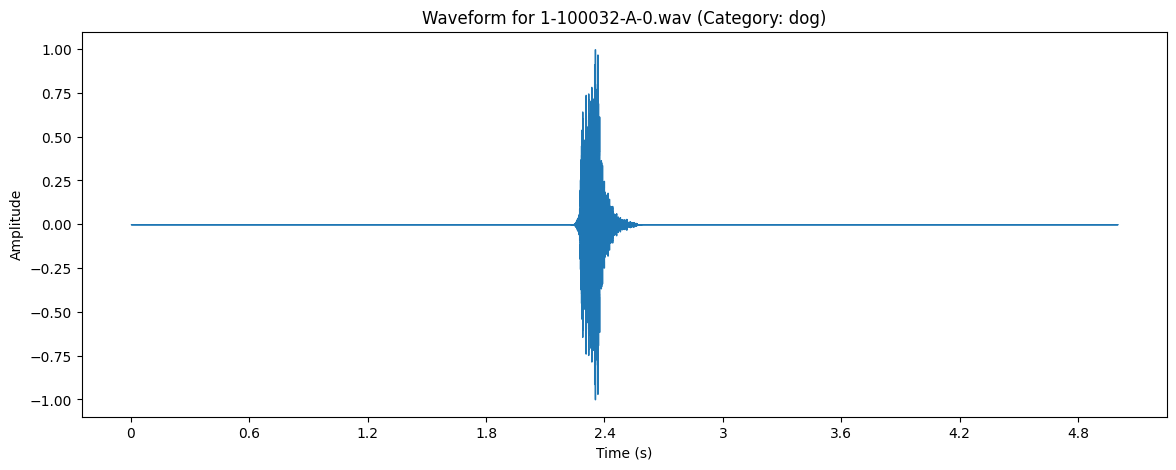

In [5]:
# Visualizing the audio waveform
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio_data, sr=sample_rate)
plt.title(f'Waveform for {meta_df.loc[0, "filename"]} (Category: {meta_df.loc[0, "category"]})')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

## Feature Engineering

We use Mel-spectrograms. These are 2D images representing the sound's frequency content over time. They work exceptionally well with Convolutional Neural Networks (CNNs).

> Why CNN?

CNNs excel at audio classification because spectrograms are 2D images (frequency × time), and CNNs naturally detect spatial patterns in 2D data. They provide translation invariance (detecting sounds regardless of when they occur), hierarchical feature learning (from simple frequency patterns to complex sound signatures), and parameter efficiency through weight sharing. Essentially, by converting audio to spectrograms, we turn sound classification into an image recognition problem where CNNs are proven to work well.

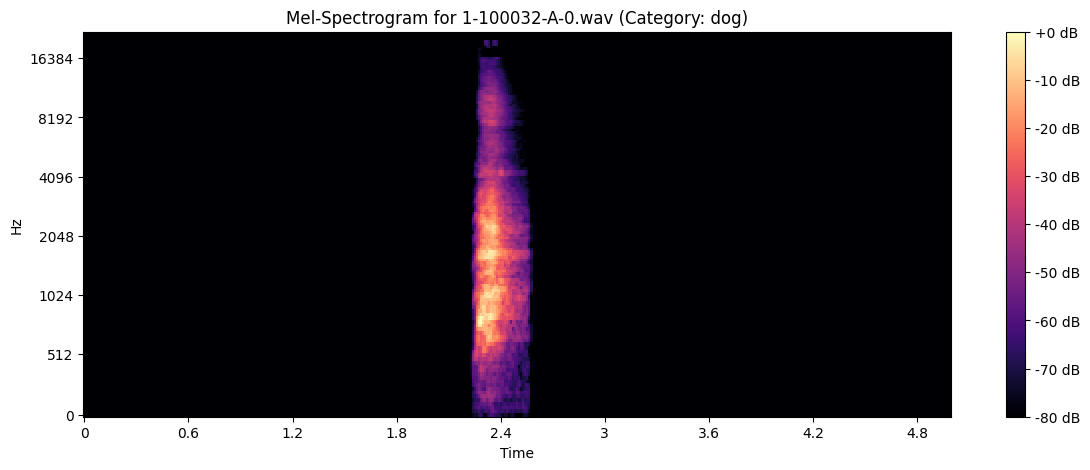

In [6]:
# Generating mel-spectrogram
mel_spectrogram = librosa.feature.melspectrogram(
    y=audio_data,
    sr=sample_rate
)

# converting to decibels
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

# visualizing
plt.figure(figsize=(14, 5))
librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title(f'Mel-Spectrogram for {meta_df.loc[0, "filename"]} (Category: {meta_df.loc[0, "category"]})')
plt.colorbar(format='%+2.0f dB')
plt.show()

This "image" is what we will feed into our neural network. The CNN will learn to recognize patterns in these spectrograms that correspond to specific sounds.

In [7]:
# Creating a function for convert every audio footage
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

def extract_features(file_path):
  try:
    audio_data, sample_rate = librosa.load(file_path,
                                           res_type='kaiser_fast',
                                           duration=5,
                                           sr=22050)
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

  except Exception as e:
    print(f"Error processing {file_path}: {e}")
    return None

In [8]:
## Loop through every file AND EXTRACT FEATURES
features=[]
labels=[]
audio_dir='ESC-50-master/audio/'

for index, row in tqdm(meta_df.iterrows(), total=meta_df.shape[0]):
  file_path = audio_dir + row['filename']
  spectrogram = extract_features(file_path)

  if spectrogram is not None:
    features.append(spectrogram)
    labels.append(row['category'])

X = np.array(features)
y = np.array(labels)

100%|██████████| 2000/2000 [03:10<00:00, 10.48it/s]


In [9]:
X.shape

(2000, 128, 216)

In [10]:
# Encoding the ategorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-hot encode the integer labels
y_one_hot = to_categorical(y_encoded)

In [11]:
y_one_hot.shape

(2000, 50)

 A CNN expects a 4D array: (batch_size, height, width, channels).
We add a 'channel' dimension of 1 for our grayscale spectrograms.

In [12]:
X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot)

print(f"(X_train): {X_train.shape}")
print(f"(X_test): {X_test.shape}")
print(f"(y_train): {y_train.shape}")
print(f"(y_test): {y_test.shape}")


(X_train): (1600, 128, 216, 1)
(X_test): (400, 128, 216, 1)
(y_train): (1600, 50)
(y_test): (400, 50)


### Model

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

In [14]:
num_classes = y_one_hot.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3),
           activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3),
           activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3),
           activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(256, activation='relu'),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 214, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 107, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 63, 107, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 105, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 52, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 52, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    11,469,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,575,474 (44.16 MB)

 Trainable params: 11,575,026 (44.16 MB)

 Non-trainable params: 448 (1.75 KB)

In [16]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data= (X_test, y_test),
    verbose=1
)

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 91ms/step - accuracy: 0.0632 - loss: 15.0622 - val_accuracy: 0.0250 - val_loss: 34.1720
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1276 - loss: 5.6714 - val_accuracy: 0.0275 - val_loss: 6.9885
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1387 - loss: 4.3623 - val_accuracy: 0.0700 - val_loss: 6.1444
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1456 - loss: 4.1450 - val_accuracy: 0.0725 - val_loss: 4.1186
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.1305 - loss: 3.8704 - val_accuracy: 0.0400 - val_loss: 4.6377
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1596 - loss: 3.7333 - val_accuracy: 0.0875 - val_loss: 4.7946
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1699 - loss: 3.5956 - val_accuracy: 0.0925 - val_loss: 7.5617
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.1890 - loss: 3.4635 - val_accuracy:

### Visualizing the model performance

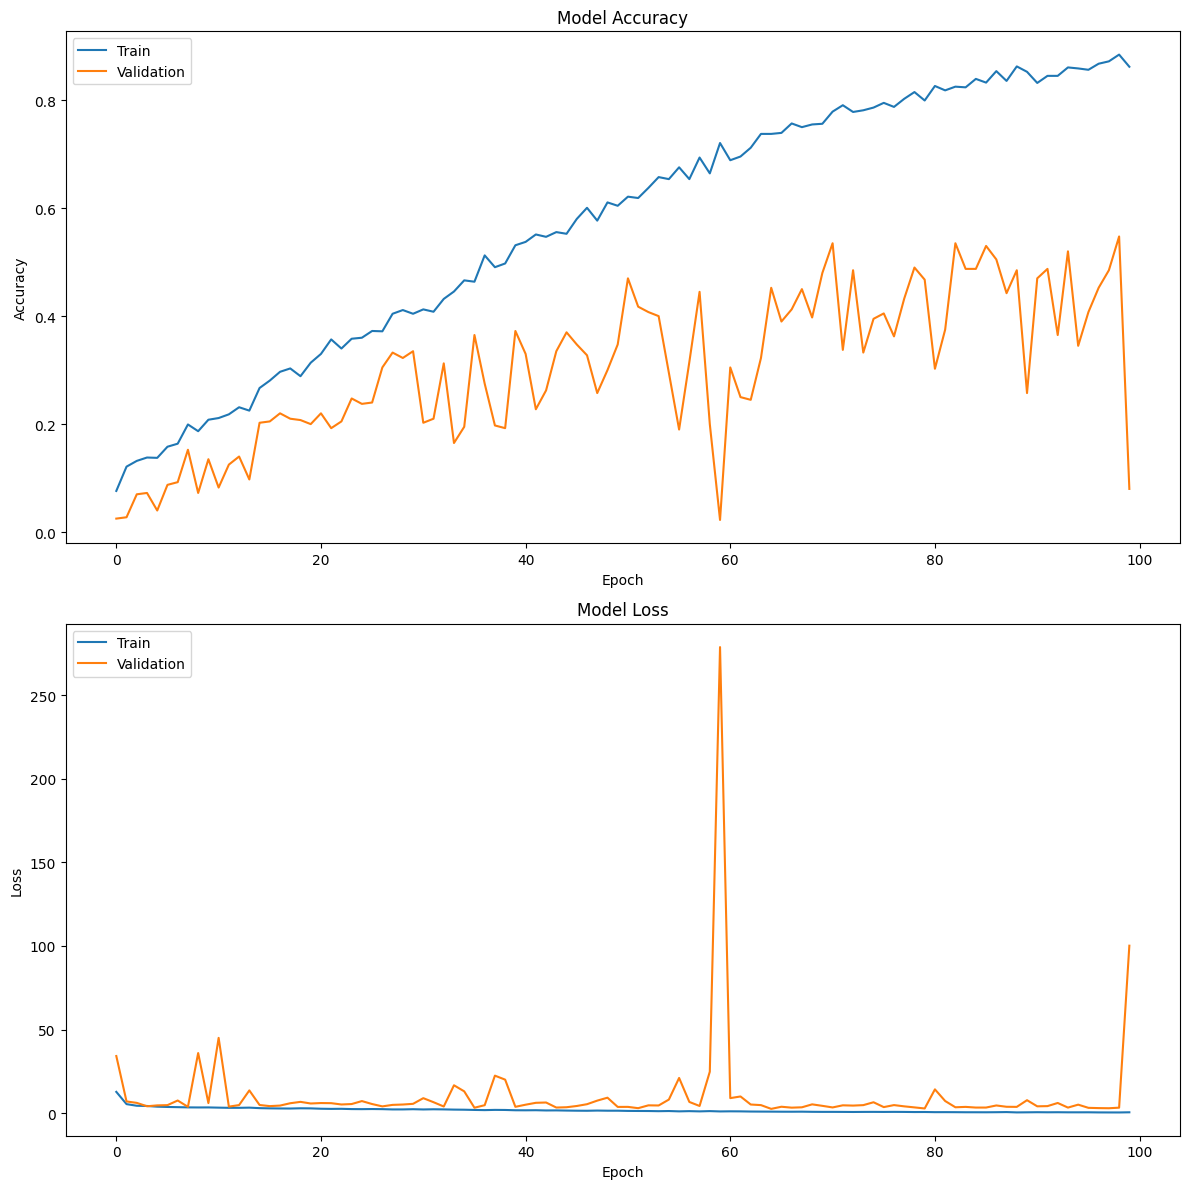

In [17]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot training & validation accuracy values
axs[0].plot(history.history['accuracy'])
axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

The model shows an overfitting behaviour

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 8.00%
Test Loss: 100.1779


In [19]:
# Get model predictions
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

class_names = label_encoder.classes_

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step
                  precision    recall  f1-score   support

        airplane       0.00      0.00      0.00         8
       breathing       0.00      0.00      0.00         8
  brushing_teeth       0.00      0.00      0.00         8
     can_opening       1.00      0.12      0.22         8
        car_horn       0.00      0.00      0.00         8
             cat       1.00      0.12      0.22         8
        chainsaw       0.00      0.00      0.00         8
  chirping_birds       0.00      0.00      0.00         8
    church_bells       0.00      0.00      0.00         8
        clapping       0.00      0.00      0.00         8
     clock_alarm       1.00      0.75      0.86         8
      clock_tick       0.00      0.00      0.00         8
        coughing       0.00      0.00      0.00         8
             cow       0.00      0.00      0.00         8
  crackling_fire       0.00      0.00      0.00         8
        crickets       0.21    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


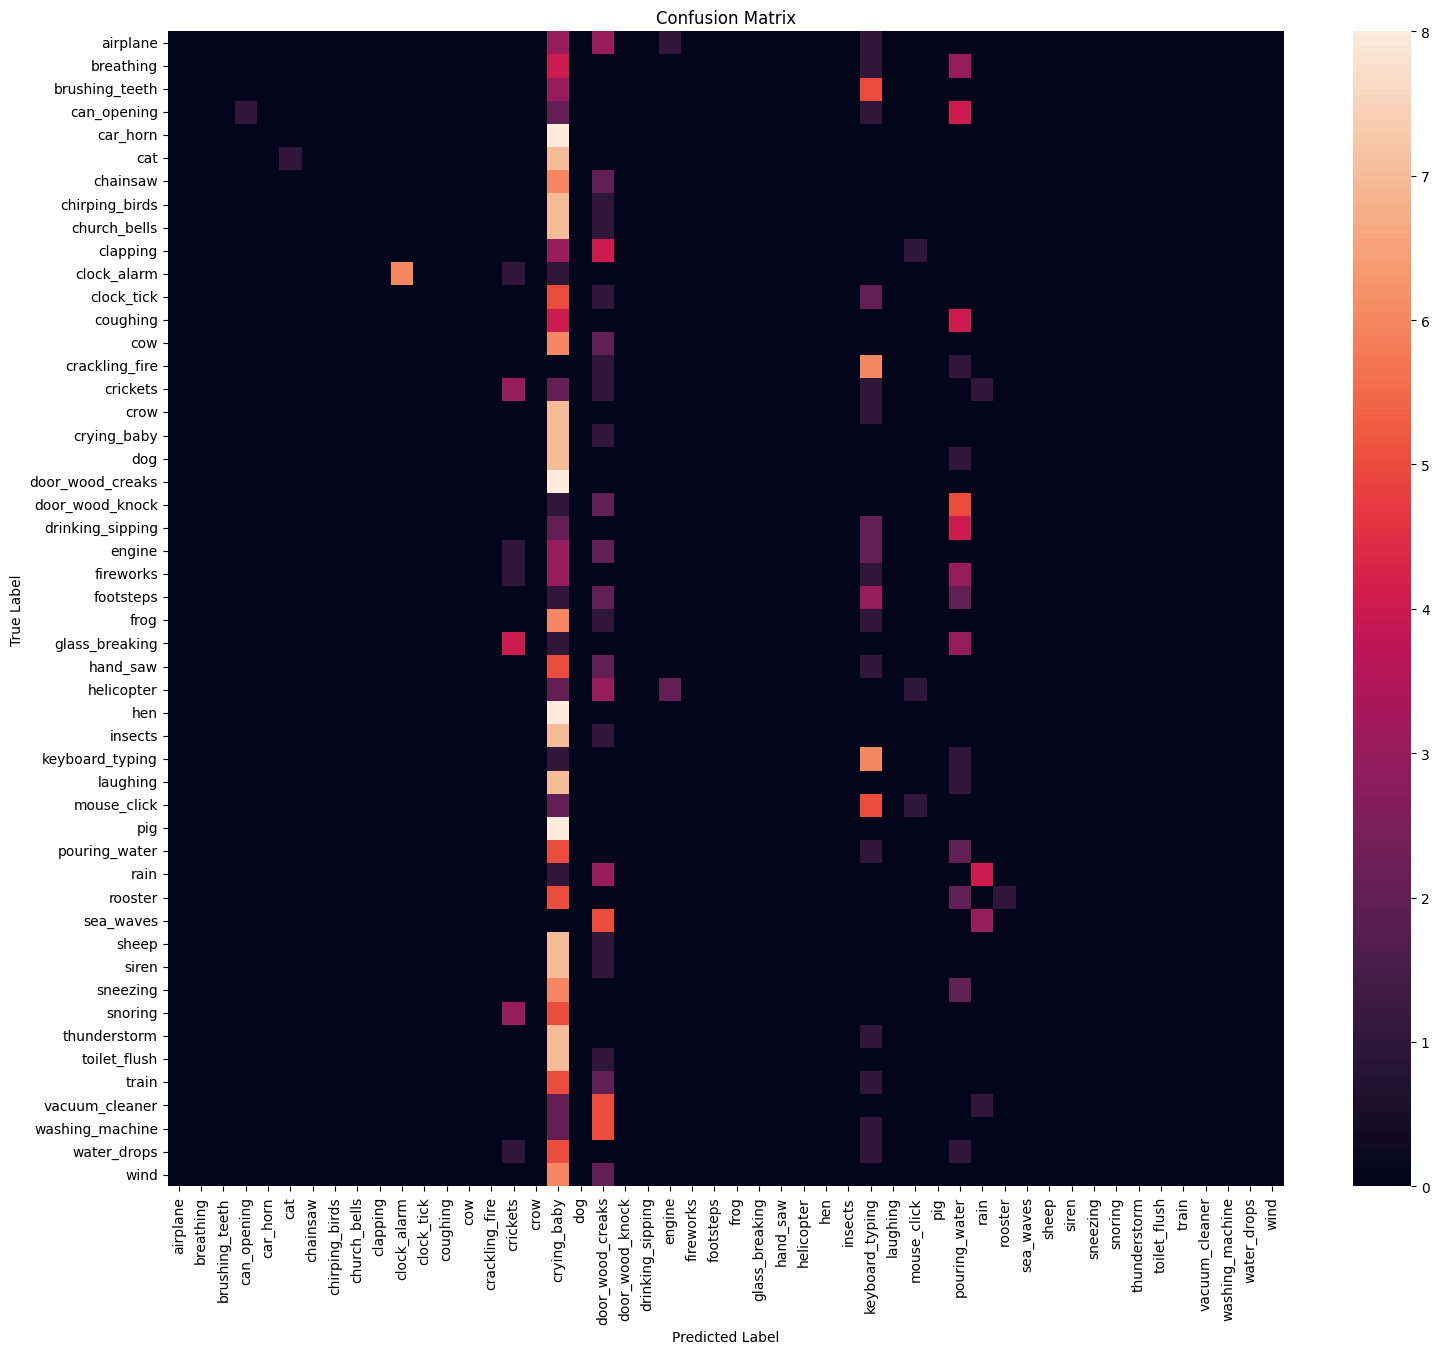

In [20]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=False, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Data augmentation

We will add data augmentations to our training set for get better performane from the model

In [28]:
# Functions for augmentation
def add_noise(data, noise_factor=0.005):
  noise = np.random.randn(len(data))
  augmented_data = data + noise_factor * noise
  # Cast back to same data type
  augmented_data = augmented_data.astype(type(data[0]))
  return augmented_data

def pitch_shift(data, sr, n_steps=4):
  return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

## update the feature extraction
def extract_features(audio_data, sr=22050):
  try:
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sr)
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    return log_mel_spectrogram

  except Exception as e:
    print(f"Error processing {file_path}: {e}")
    return None

In [23]:
## Load original data

features = []
labels = []
audio_dir = 'ESC-50-master/audio/'

for index, row in tqdm(meta_df.iterrows(), total=meta_df.shape[0]):
    file_path = audio_dir + row['filename']
    audio_data, sr = librosa.load(file_path, res_type='kaiser_fast', duration=5, sr=22050)

    if audio_data is not None:
        features.append(audio_data) # Store raw audio for now
        labels.append(row['category'])

100%|██████████| 2000/2000 [01:55<00:00, 17.38it/s]


In [24]:
## Encode labels and split the original data
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(np.array(labels))
y_one_hot = to_categorical(y_encoded)
X_train_audio, X_test_audio, y_train, y_test = train_test_split(features, y_one_hot, test_size=0.2, random_state=42, stratify=y_one_hot)

In [29]:
## Creating augmented data
X_train_augmented_audio = []
y_train_augmented = []

for i, audio_sample in tqdm(enumerate(X_train_audio), total=len(X_train_audio)):
    sr = 22050 # Assuming constant sample rate
    # Original sample
    X_train_augmented_audio.append(audio_sample)
    y_train_augmented.append(y_train[i])

    # Augmented sample with noise
    noisy_audio = add_noise(audio_sample)
    X_train_augmented_audio.append(noisy_audio)
    y_train_augmented.append(y_train[i])

    # Augmented sample with pitch shift
    pitched_audio = pitch_shift(audio_sample, sr)
    X_train_augmented_audio.append(pitched_audio)
    y_train_augmented.append(y_train[i])

## Convert all audio to spectrograms
X_train = np.array([extract_features(x) for x in tqdm(X_train_augmented_audio)])
X_test = np.array([extract_features(x) for x in tqdm(X_test_audio)])
y_train = np.array(y_train_augmented)

## Reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")


100%|██████████| 400/400 [00:04<00:00, 92.10it/s]

Shape of X_train: (4800, 128, 216, 1)
Shape of X_test: (400, 128, 216, 1)


In [30]:
## Fit to the same model before

num_epochs = 100
batch_size = 32

history2 = model.fit(
    X_train,
    y_train,
    epochs=num_epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6120 - loss: 1.9117 - val_accuracy: 0.2525 - val_loss: 19.3308
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6936 - loss: 1.2252 - val_accuracy: 0.3100 - val_loss: 5.8369
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.7331 - loss: 0.9982 - val_accuracy: 0.3825 - val_loss: 4.9424
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.7941 - loss: 0.7570 - val_accuracy: 0.4425 - val_loss: 3.0953
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8037 - loss: 0.6769 - val_accuracy: 0.4225 - val_loss: 3.3583
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8282 - loss: 0.5678 - val_accuracy: 0.5125 - val_loss: 3.6589
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.8534 - loss: 0.4955 - val_accuracy: 0.4300 - val_loss: 4.2214
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8617 - loss: 0.4629 -

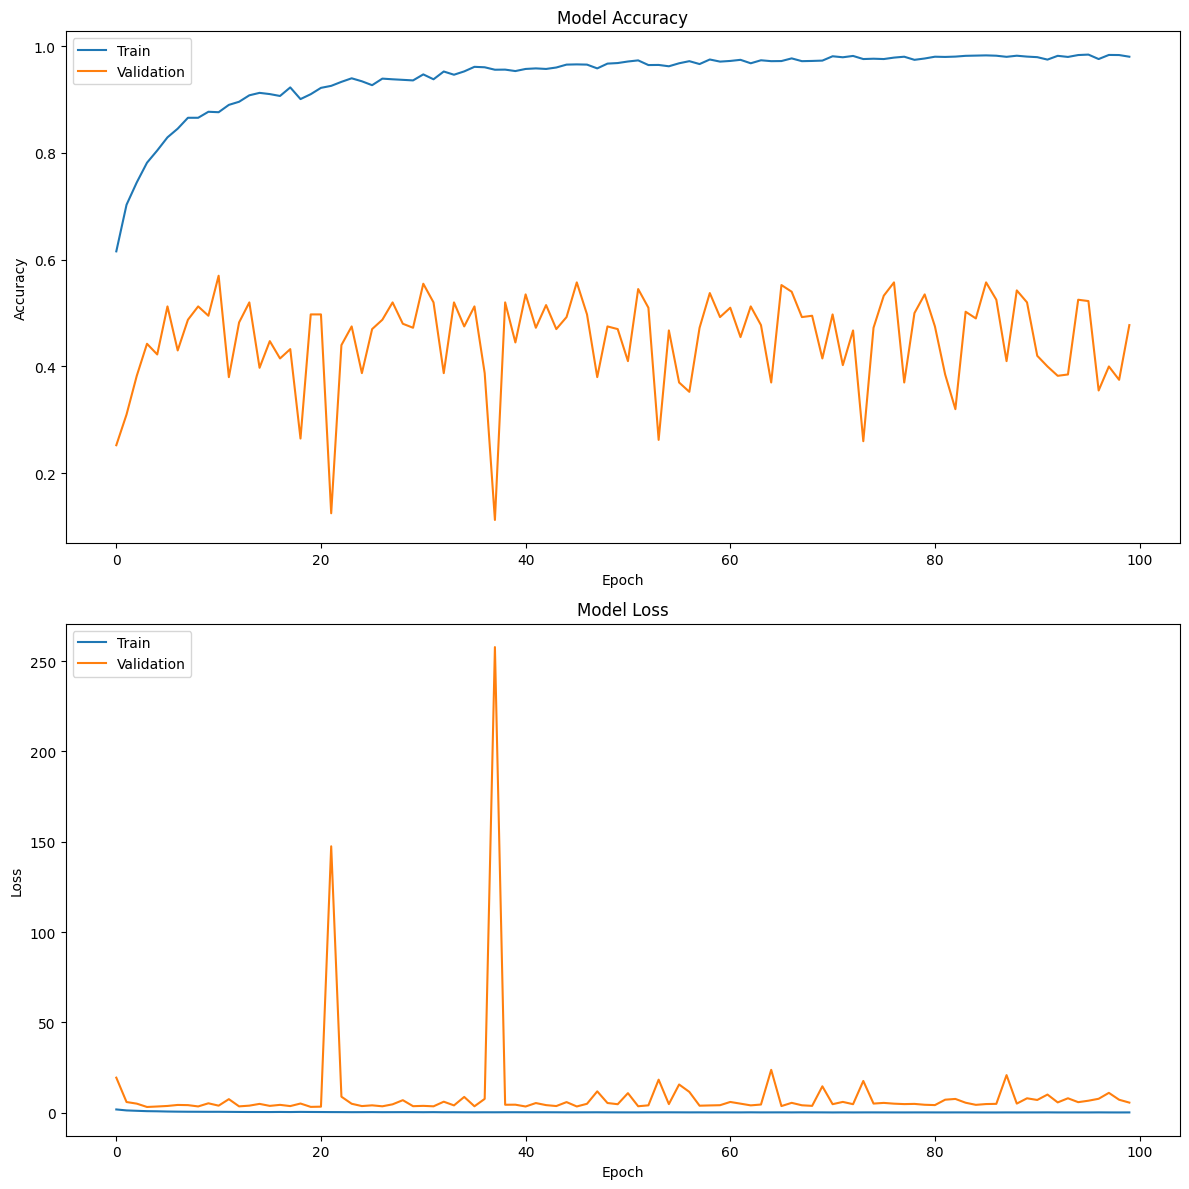

In [33]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot training & validation accuracy values
axs[0].plot(history2.history['accuracy'])
axs[0].plot(history2.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history2.history['loss'])
axs[1].plot(history2.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

This time the model performance got wore, now we try to impliment the model with some reqularizations, and learning rate variations.

In [34]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

num_classes = y_one_hot.shape[1]
input_shape = (X_train.shape[1], X_train.shape[2], 1)

model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),

    Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

## Compile the model (same as before)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Define learning rate callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

## Train the new model
history3 = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.0469 - loss: 9.4163 - val_accuracy: 0.0450 - val_loss: 5.0464 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0595 - loss: 5.1831 - val_accuracy: 0.0200 - val_loss: 7.8143 - learning_rate: 0.0010
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.0711 - loss: 5.1094 - val_accuracy: 0.0425 - val_loss: 15.8292 - learning_rate: 0.0010
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0655 - loss: 5.1362 - val_accuracy: 0.0850 - val_loss: 21.7515 - learning_rate: 0.0010
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.0677 - loss: 5.2120 - val_accuracy: 0.0675 - val_loss: 9.4317 - learning_rate: 0.0010
Epoch 6/100
149/150 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.0665 - loss: 5.0513
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.0666 -

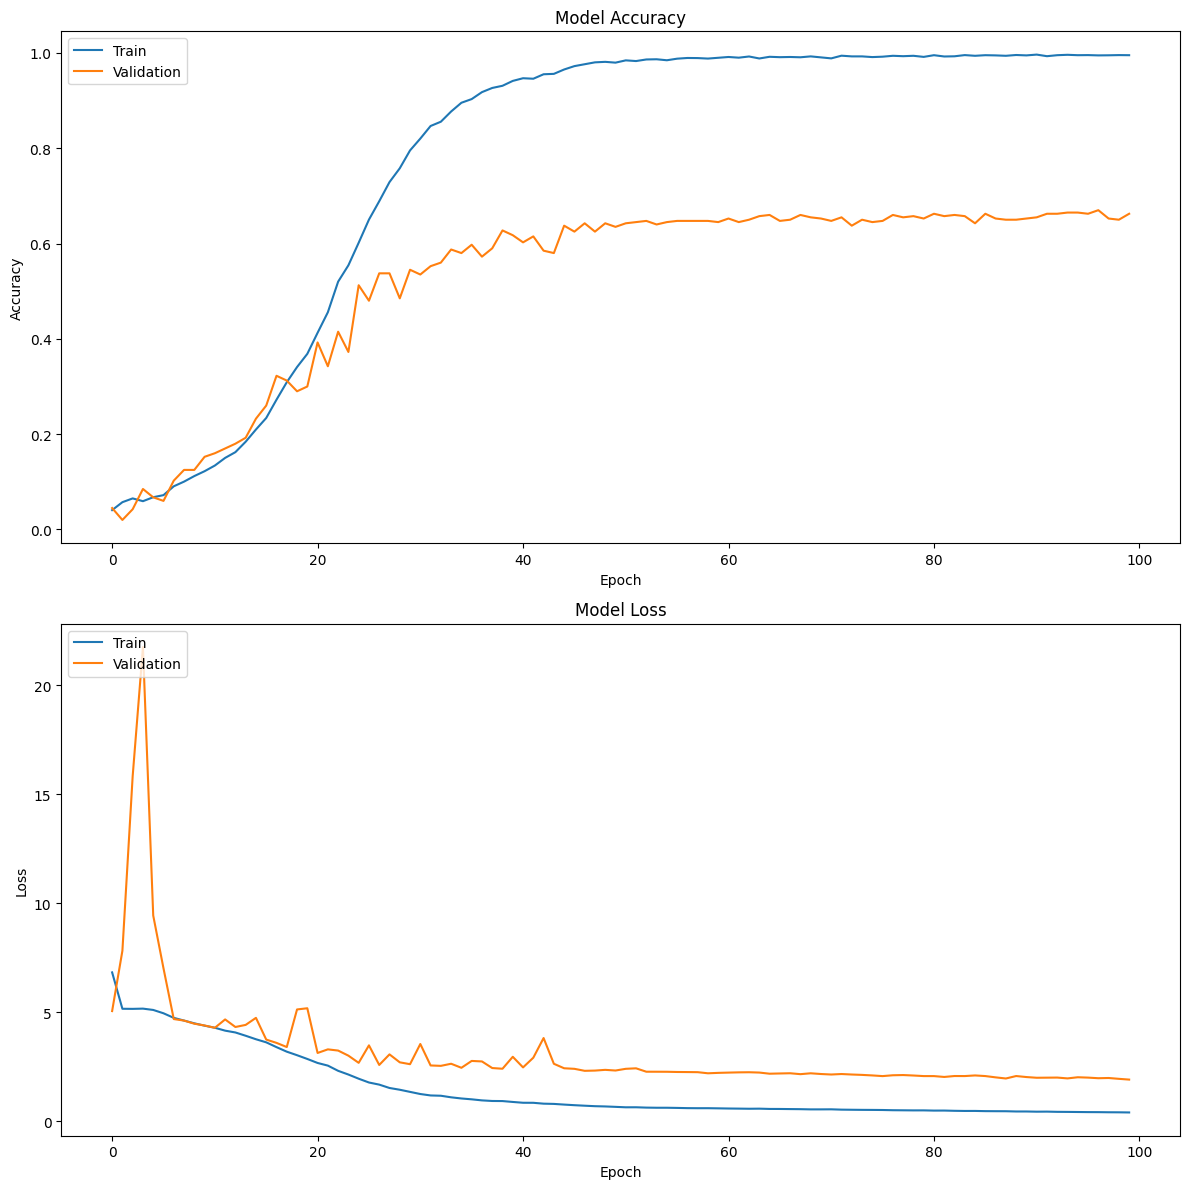

In [36]:
fig, axs = plt.subplots(2, 1, figsize=(12, 12))

# Plot training & validation accuracy values
axs[0].plot(history3.history['accuracy'])
axs[0].plot(history3.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axs[1].plot(history3.history['loss'])
axs[1].plot(history3.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

### Evaluation

In [37]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 66.25%
Test Loss: 1.9020


In [38]:
# Get model predictions
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

class_names = label_encoder.classes_

# Classification report
print(classification_report(y_true_labels, y_pred_labels, target_names=class_names))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
                  precision    recall  f1-score   support

        airplane       0.75      0.38      0.50         8
       breathing       0.33      0.50      0.40         8
  brushing_teeth       1.00      0.88      0.93         8
     can_opening       0.55      0.75      0.63         8
        car_horn       1.00      0.88      0.93         8
             cat       0.86      0.75      0.80         8
        chainsaw       1.00      0.75      0.86         8
  chirping_birds       0.50      0.38      0.43         8
    church_bells       0.80      1.00      0.89         8
        clapping       0.58      0.88      0.70         8
     clock_alarm       0.89      1.00      0.94         8
      clock_tick       0.55      0.75      0.63         8
        coughing       0.88      0.88      0.88         8
             cow       0.80      1.00      0.89         8
  crackling_fire       0.75      0.38      0.50         8
        crickets       0.57    

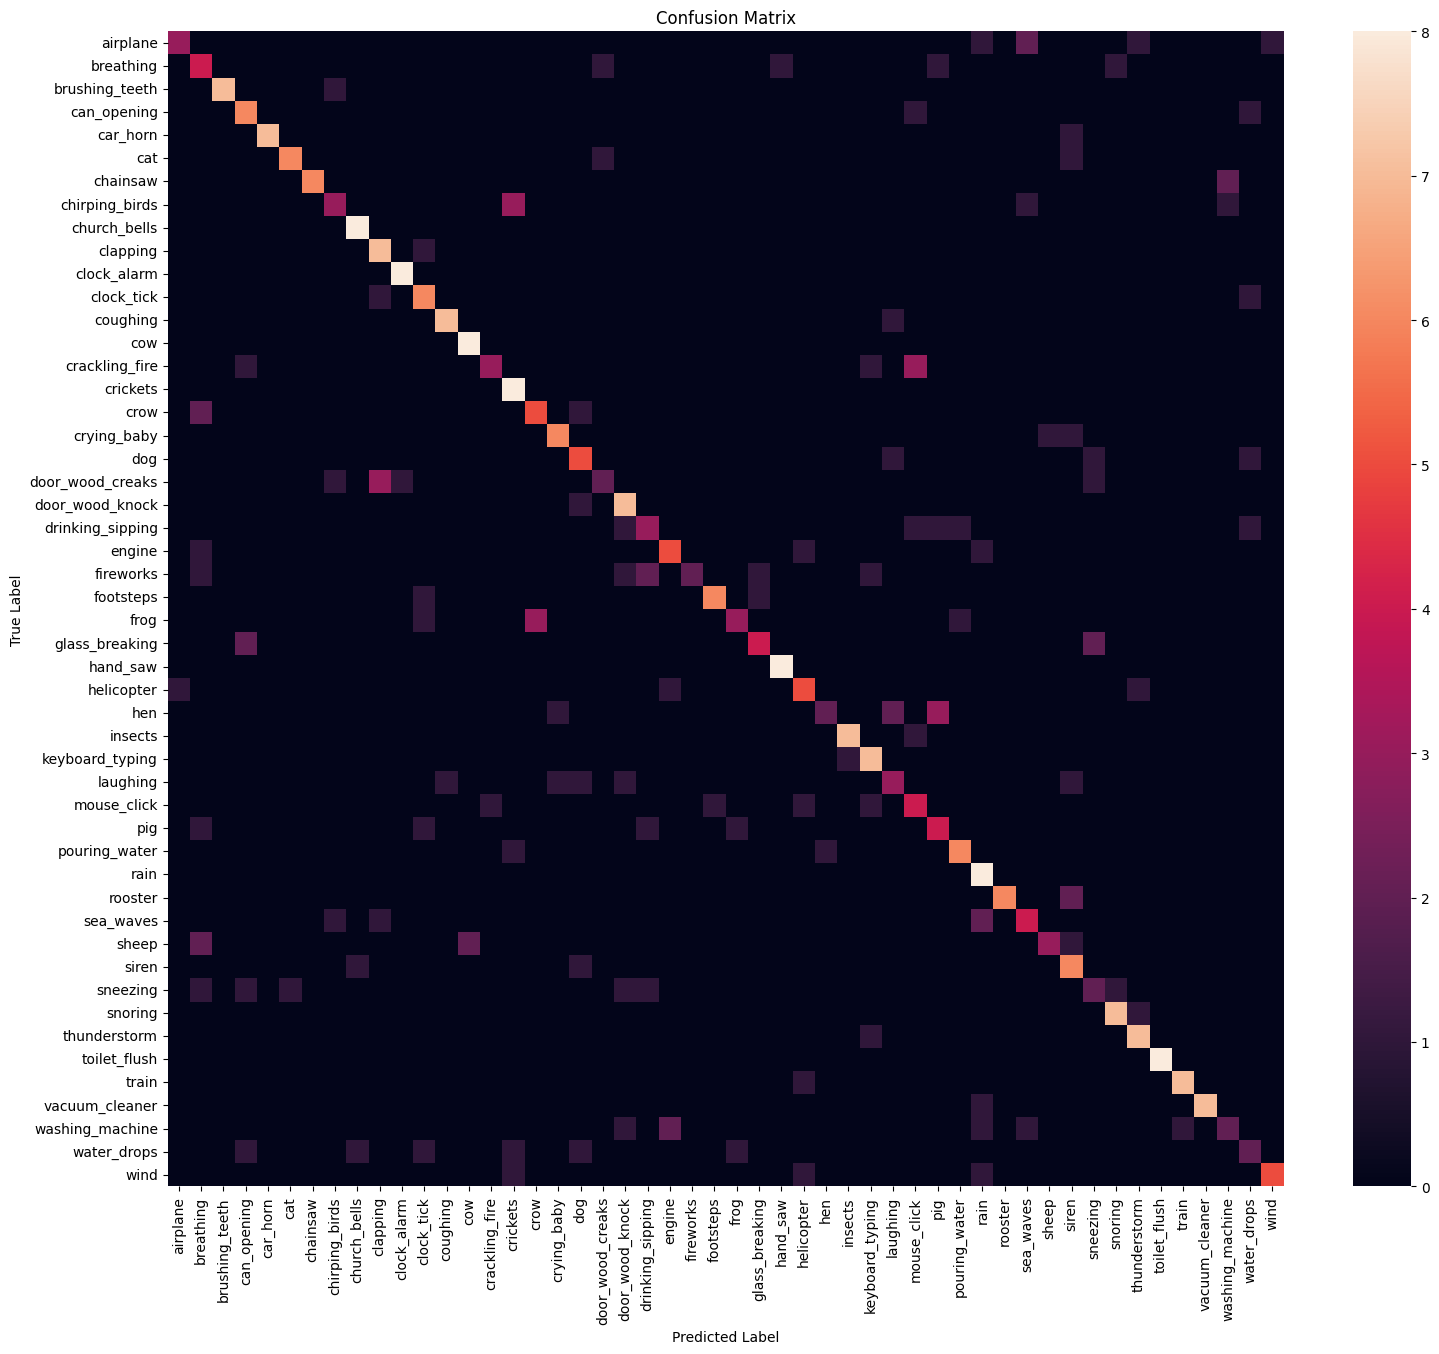

In [39]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(18, 15))
sns.heatmap(conf_matrix, annot=False, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

This model is somewhat satisfiable, befor doing more experiments first we should save it

In [40]:
# Define the file path for the saved model
model_path = 'echosense_model.keras'

# Save the model
model.save(model_path)

In [41]:
import pickle

# Define the file path for the label encoder
encoder_path = 'label_encoder.pkl'

# Save the label encoder object using pickle
with open(encoder_path, 'wb') as f:
    pickle.dump(label_encoder, f)